In [1]:
import pandas as pd
import numpy as np
import jieba
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input,LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.layers.core import SpatialDropout1D
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']="SimHei"
plt.rcParams['axes.unicode_minus']=False
plt.style.use('ggplot')

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data1=pd.read_excel("C题全部数据/附件1.xlsx")
data2=pd.read_excel("C题全部数据/附件2.xlsx")
data3=pd.read_excel("C题全部数据/附件3.xlsx")
data4=pd.read_excel("C题全部数据/附件4.xlsx")

In [3]:
data1.head()

,一级分类,二级分类,三级分类
0,城乡建设,安全生产,事故处理
1,城乡建设,安全生产,安全生产管理
2,城乡建设,安全生产,安全隐患
3,城乡建设,城市建设和市政管理,园林绿化环卫
4,城乡建设,城市建设和市政管理,城管执法


In [4]:
data2.head()

,留言编号,留言用户,留言主题,留言时间,留言详情,一级标签
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,城乡建设
1,37,U0008473,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,城乡建设
2,83,A00063999,投诉A市A1区苑物业违规收停车费,2019/12/30 17:06:14,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的领导：A1区苑小区位于A1区火炬路，小...,城乡建设
3,303,U0007137,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,2019/12/6 14:40:14,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设
4,319,U0007137,A1区A2区华庭自来水好大一股霉味,2019/12/5 11:17:22,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,城乡建设


In [5]:
data3.head()

,留言编号,留言用户,留言主题,留言时间,留言详情,反对数,点赞数
0,188006,A000102948,A3区一米阳光婚纱艺术摄影是否合法纳税了？,2019/2/28 11:25:05,\n\t\t\t\t\t\n\t\t\t\t\t座落在A市A3区联丰路米兰春天G2栋320，...,0,0
1,188007,A00074795,咨询A6区道路命名规划初步成果公示和城乡门牌问题,2019/2/14 20:00:00,\n\t\t\t\t\t\n\t\t\t\t\tA市A6区道路命名规划已经初步成果公示文件，...,0,1
2,188031,A00040066,反映A7县春华镇金鼎村水泥路、自来水到户的问题,2019/7/19 18:19:54,\n\t\t\t\t\t\n\t\t\t\t\t本人系春华镇金鼎村七里组村民，不知是否有相关...,0,1
3,188039,A00081379,A2区黄兴路步行街大古道巷住户卫生间粪便外排,2019/8/19 11:48:23,\n\t\t\t\t\t\n\t\t\t\t\t靠近黄兴路步行街，城南路街道、大古道巷、一步...,0,1
4,188059,A00028571,A市A3区中海国际社区三期与四期中间空地夜间施工噪音扰民,2019/11/22 16:54:42,\n\t\t\t\t\t\n\t\t\t\t\tA市A3区中海国际社区三期四期中间，即蓝天璞...,0,0


In [6]:
data4.head()

,留言编号,留言用户,留言主题,留言时间,留言详情,答复意见,答复时间
0,2549,A00045581,A2区景蓉华苑物业管理有问题,2019/4/25 9:32:09,\n\t\t\t\t\t\n\t\t\t\t\t2019年4月以来，位于A市A2区桂花坪街道...,现将网友在平台《问政西地省》栏目向胡华衡书记留言反映“A2区景蓉花苑物业管理有问题”的调查核...,2019/5/10 14:56:53
1,2554,A00023583,A3区潇楚南路洋湖段怎么还没修好？,2019/4/24 16:03:40,\n\t\t\t\t\t\n\t\t\t\t\t潇楚南路从2018年开始修，到现在都快一年了...,"网友“A00023583”：您好！针对您反映A3区潇楚南路洋湖段怎么还没修好的问题,A3区洋...",2019/5/9 9:49:10
2,2555,A00031618,请加快提高A市民营幼儿园老师的待遇,2019/4/24 15:40:04,\n\t\t\t\t\t\n\t\t\t\t\t地处省会A市民营幼儿园众多，小孩是祖国的未来...,市民同志：你好！您反映的“请加快提高民营幼儿园教师的待遇”的来信已收悉。现回复如下：为了改善...,2019/5/9 9:49:14
3,2557,A000110735,在A市买公寓能享受人才新政购房补贴吗？,2019/4/24 15:07:30,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的书记：您好！我研究生毕业后根据人才新政...,网友“A000110735”：您好！您在平台《问政西地省》上的留言已收悉，市住建局及时将您反...,2019/5/9 9:49:42
4,2574,A0009233,关于A市公交站点名称变更的建议,2019/4/23 17:03:19,\n\t\t\t\t\t\n\t\t\t\t\t建议将“白竹坡路口”更名为“马坡岭小学”，原...,网友“A0009233”，您好，您的留言已收悉，现将具体内容答复如下：关于来信人建议“白竹坡...,2019/5/9 9:51:30


# 1、群众留言分类
   * 目标：根据data1中的分类标签  对data2中的主题进行分类  
     
   * <font color="red"> 数据预处理思路：  
     
     * <font color="red"> 1.提取附件2中的“留言详情”、“一级标签” 作为训练的数据和标签
     * <font color="red"> 2.将一级标签中的各个分类文本转换为一一对应的数字
     * <font color="red"> 3.定义正则表达式删除除字母,数字，汉字以外的所有符号的函数
     * <font color="red"> 4.加载停用词表，去停用词后分词

### **1.1数据探索**

In [7]:
data2.isnull().sum()

留言编号    0
留言用户    0
留言主题    0
留言时间    0
留言详情    0
一级标签    0
dtype: int64

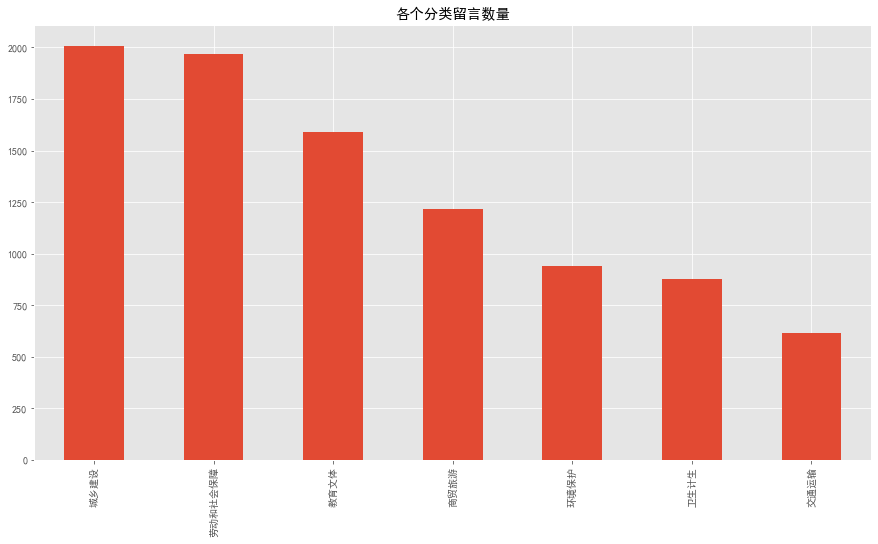

In [8]:
q1_x=data2[["留言主题","留言详情"]]#训练数据
q1_y=data2[["一级标签"]]#标签
q1_y["一级标签"].value_counts().plot(kind="bar",figsize=(15,8),title="各个分类留言数量")
plt.show()

### 1.2数据预处理

In [40]:
test=data2[["一级标签","留言详情"]]
#重命名列名
test.columns=["cat","review"]

test['cat_id'] = test['cat'].factorize()[0]
cat_id_df = test[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
test.sample(10)

,cat,review,cat_id
2032,环境保护,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的市丶区委领导∶\r\n 5月底在我家...,1
293,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t张县长，你好！ 我是居住于A7县开慧镇飘峰...,0
4454,教育文体,\n \n 周局长，您也当过老师，学生教育靠老师，不是靠领导，又说管理...,3
555,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t 您有没有觉得D市的树太少了，我市在大规模...,0
7688,商贸旅游,\n\t\t\t\t\t\n\t\t\t\t\t如题，一块水表要750块，上户也说要1600...,5
2440,环境保护,\n\t\t\t\t\t\n\t\t\t\t\t 尊敬的环保局领导： 您们好！ 向您们...,1
6956,劳动和社会保障,\n \n 产假工资怎么发放，申请产假工资需要提交哪些资料，在哪里办理，是一...,4
1698,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t 按照住建部、财政部、人民银行三部委与20...,0
8485,卫生计生,\n \n 近年来，非法行医如雨后春笋，卫生行政部门罚款了事，医疗环境相...,6
5762,劳动和社会保障,\n \n 尊敬的领导 我们是A市A4区精冠机械公司的全体员工。我们公司从...,4


In [30]:
cat_id_df

,cat,cat_id
0,城乡建设,0
1,环境保护,1
2,交通运输,2
3,教育文体,3
4,劳动和社会保障,4
5,商贸旅游,5
6,卫生计生,6


In [41]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
#加载停用词文件
def stopwordslist(filepath,encoding="utf-8"):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding=encoding).readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("stopword.txt",encoding="GB18030")
#删除除字母,数字，汉字以外的所有符号
test['clean_review'] = test['review'].apply(remove_punctuation)
#分词，并过滤停用词
test['cut_review'] = test['clean_review'].apply(lambda x: " ".join([w for w in list(jieba.cut(x)) if w not in stopwords]))
test.head()

,cat,review,cat_id,clean_review,cut_review
0,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,0,A3区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工...,A3 区 大道 西行 便道 未管 路口 加油站 路段 人行道 包括 路灯 杆 圈 西湖 建筑...
1,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,0,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水电等设施后烂尾多年用护栏围着不但占用人行道...,位于 书院 路 主干道 在水一方 大厦 一楼 四楼 人为 拆除 水电 设施 烂尾 多年 护栏...
2,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的领导：A1区苑小区位于A1区火炬路，小...,0,尊敬的领导A1区苑小区位于A1区火炬路小区物业A市程明物业管理有限公司未经小区业主同意利用业...,尊敬 领导 A1 区苑 小区 位于 A1 区 火炬 路 小区 物业 市程明 物业管理 有限公...
3,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 自来水 龙头 水 霉...
4,城乡建设,\n\t\t\t\t\t\n\t\t\t\t\tA1区A2区华庭小区高层为二次供水，楼顶水箱...,0,A1区A2区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我...,A1 区 A2 区华庭 小区 高层 二次 供水 楼顶 水箱 长年 不洗 自来水 龙头 水 霉...


In [43]:
test1=test[['cat_id','review']]
test1.info()
test1.head()

test1_X=test1['review']
test1_Y=test1['cat_id']

X_train,X_test,y_train,y_test=train_test_split(test1_X,test1_Y,test_size=0.2,random_state=20)

train=pd.DataFrame({'label':y_train,'comment':X_train},index=None)
test=pd.DataFrame({'label':y_test,'comment':X_test},index=None)
train.head()

train.to_csv('./train.csv',encoding='utf-8')
test.to_csv('./test.csv',encoding='utf-8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9210 entries, 0 to 9209
Data columns (total 2 columns):
cat_id    9210 non-null int64
review    9210 non-null object
dtypes: int64(1), object(1)
memory usage: 144.0+ KB


### **1.3 模型构建**

In [12]:
# 设置最频繁使用的50000个词
MAX_NB_WORDS =10000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 200
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 256
 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(test['cut_review'].values)
word_index = tokenizer.word_index
print('共有 %s 个不相同的词语.' % len(word_index))

X = tokenizer.texts_to_sequences(test['cut_review'].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

#多类标签的onehot展开
Y = pd.get_dummies(test['cat_id']).values
 
print(X.shape)
print(Y.shape)

共有 82918 个不相同的词语.
(9210, 200)
(9210, 7)


In [13]:
#拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,stratify=Y,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
#定义模型
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128,dropout=0.3,recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 20
batch_size = 64
 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

(7368, 200) (7368, 7)
(1842, 200) (1842, 7)
Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 256)          2560000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 2,758,023
Trainable params: 2,758,023
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 5894 samples, validate on 1474 samples
Epoch 1/20
5894/5894 [===

### **1.4LSTM模型评估**

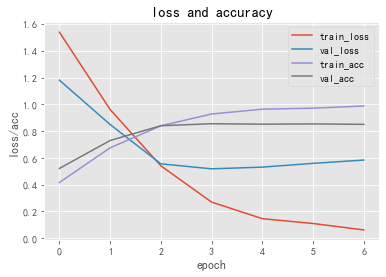

In [15]:
N=7
plt.plot(np.arange(0,N),history.history["loss"],label ="train_loss")
plt.plot(np.arange(0,N),history.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),history.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),history.history["val_accuracy"],label="val_acc")
plt.title("loss and accuracy")
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.legend(loc="best")
plt.show()

Text(0.5, 1, 'LSTM混淆矩阵:准确率(83.88%)')

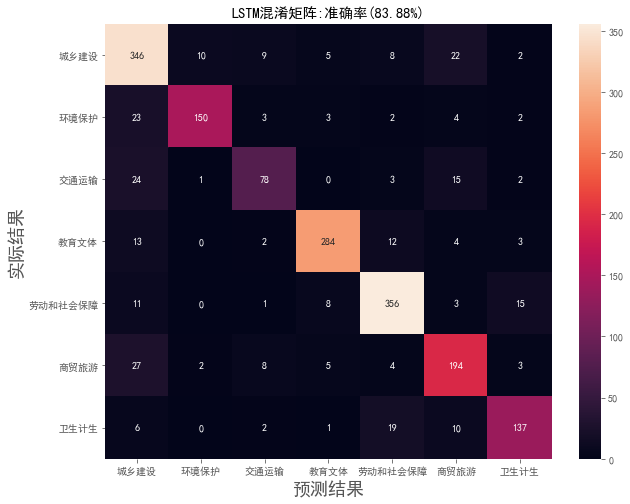

In [16]:

Y_pred = model.predict(X_test)
y_pred = Y_pred.argmax(axis = 1)
y_test = Y_test.argmax(axis = 1)
 
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.title("LSTM混淆矩阵:准确率({:.2f}%)".format(accuracy_score(y_test,y_pred)*100))

In [17]:
def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        if(len(row_data)==1):
            continue
        row['class'] = row_data[1].strip()
        try:
            row['precision'] = float(row_data[2])
        except:
            row['precision'] = " "
        try:
             row['recall'] = float(row_data[3])
        except:
            row['recall'] = " "
       
        row['f1_score'] = float(row_data[4])
        row['support'] = float(row_data[5])
        report_data.append(row)
    for line in lines[-3:]:
        row = {}
        row_data = line.split('      ')
        if(len(row_data)==1):
            continue
        row['class'] = row_data[0].strip()
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe=dataframe.set_index("class")
    return dataframe
print("LSTM模型分类评估报告")
classifaction_report_csv(classification_report(y_test,y_pred))

LSTM模型分类评估报告


,f1_score,precision,recall,support
class,,,,
0,0.81,0.77,0.86,402.0
1,0.86,0.92,0.8,187.0
2,0.69,0.76,0.63,123.0
3,0.91,0.93,0.89,318.0
4,0.89,0.88,0.9,394.0
5,0.78,0.77,0.8,243.0
6,0.81,0.84,0.78,175.0
,0.84,,,1842.0
macro avg,0.82,0.84,0.81,1842.0


In [18]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       402
           1       0.92      0.80      0.86       187
           2       0.76      0.63      0.69       123
           3       0.93      0.89      0.91       318
           4       0.88      0.90      0.89       394
           5       0.77      0.80      0.78       243
           6       0.84      0.78      0.81       175

    accuracy                           0.84      1842
   macro avg       0.84      0.81      0.82      1842
weighted avg       0.84      0.84      0.84      1842



In [22]:
F1=f1_score(y_test,y_pred,average='weighted')
print("F1为:",F1)

F1为: 0.8385526340864092


In [2]:
import pandas as pd
import os
import codecs, gc
import numpy as np
from sklearn.model_selection import KFold
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras.metrics import top_k_categorical_accuracy
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn import metrics
# 读取训练集和测试集
from sklearn.model_selection import train_test_split
 
# 参数配置
maxlen      =100  # 设置序列长度为100，要保证序列长度不超过512
Batch_size  = 8   #批量运行的个数
Epoch       = 1    #迭代次数
 
def get_train_test_data():
    train_df = pd.read_csv(r'./train.csv',encoding='gbk').astype(str)
    test_df = pd.read_csv(r'./test.csv',encoding='gbk').astype(str)
 
    # 训练数据、测试数据和标签转化为模型输入格式
    DATA_LIST = []
    for data_row in train_df.iloc[:].itertuples():
        DATA_LIST.append((data_row.comment, to_categorical(data_row.label, 7)))
    DATA_LIST = np.array(DATA_LIST)
    DATA_LIST_TEST = []
    for data_row in test_df.iloc[:].itertuples():
        DATA_LIST_TEST.append((data_row.comment, to_categorical(data_row.label,7)))
    DATA_LIST_TEST = np.array(DATA_LIST_TEST)
 
    data = DATA_LIST
    data_test = DATA_LIST_TEST
 
    X_train,X_valid = train_test_split(data,test_size=0.2,random_state = 0)
    return X_train,X_valid,data_test
 
# 预训练好的模型 roberta_wwm_ext_large
# config_path     = r'roberta_wwm_ext_large\bert_config.json' # 加载配置文件
# checkpoint_path = r'roberta_wwm_ext_large\bert_model.ckpt'
# dict_path       = r'roberta_wwm_ext_large\vocab.txt'
 
# 预训练好的模型 bert base
config_path     = r'./bert_config.json' # 加载配置文件
checkpoint_path = r'./bert_model.ckpt'
dict_path       = r'./vocab.txt'
 
def get_token_dict():
    """
    # 将词表中的字编号转换为字典
    :return: 返回自编码字典
    """
    token_dict = {}
    with codecs.open(dict_path, 'r', 'utf8') as reader:
        for line in reader:
            token = line.strip()
            token_dict[token] = len(token_dict)
    return token_dict
 
# 重写tokenizer
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示   UNK是unknown的意思
        return R
    
# 获取新的tokenizer
tokenizer = OurTokenizer(get_token_dict())
 
def seq_padding(X, padding=0):
    """
    :param X: 文本列表
    :param padding: 填充为0
    :return: 让每条文本的长度相同，用0填充
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([ np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])
 
class data_generator:
    """
    data_generator只是一种为了节约内存的数据方式
    """
    def __init__(self, data, batch_size=Batch_size, shuffle=True):
        """
        :param data: 训练的文本列表
        :param batch_size:  每次训练的个数
        :param shuffle: 文本是否打乱
        """
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
 
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []
 
 
def acc_top2(y_true, y_pred):
    """
    :param y_true: 真实值
    :param y_pred: 训练值
    :return: # 计算top-k正确率,当预测值的前k个值中存在目标类别即认为预测正确
    """
    return top_k_categorical_accuracy(y_true, y_pred, k=7)
 
# bert模型设置
def build_bert(nclass):
    """
    :param nclass: 文本分类种类
    :return: 构建的bert模型
    """
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  # 加载预训练模型
 
    for l in bert_model.layers:
        l.trainable = True
    #构建模型
    x1_in = Input(shape=(None,))
    x2_in = Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    x = Lambda(lambda x: x[:, 0])(x)  # 取出[CLS]对应的向量用来做分类
    p = Dense(nclass, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-5),  # 用足够小的学习率
                  metrics=['accuracy', acc_top2])
    print(model.summary())
    return model
 
def run_kb():
    """
    训练模型
    :return: 验证预测集，测试预测集，训练好的模型
    """
    # 搭建模型参数
    print('正在加载模型，请耐心等待....')
    model = build_bert(7)  # 7分类模型
    print('模型加载成功，开始训练....')
    early_stopping = EarlyStopping(monitor='val_acc', patience=3)  # 早停法，防止过拟合
    plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=3)  # 当评价指标不在提升时，减少学习率
    checkpoint = ModelCheckpoint(r'./bert_dump1.hdf5', monitor='val_acc', verbose=2,
                                 save_best_only=True, mode='max', save_weights_only=True)  # 保存最好的模型
    # 获取数据并文本序列化
    X_train, X_valid, data_test = get_train_test_data()
    train_D = data_generator(X_train, shuffle=True)
    valid_D = data_generator(X_valid, shuffle=True)
    test_D = data_generator(data_test, shuffle=False)
 
    # 模型训练
    model.fit_generator(
        train_D.__iter__(),
        steps_per_epoch=len(train_D),
        epochs=Epoch,
        validation_data=valid_D.__iter__(),
        validation_steps=len(valid_D),
        callbacks=[early_stopping, plateau, checkpoint],
        )
    # 对验证集和测试集进行预测
    valid_D = data_generator(X_valid, shuffle=False)
    train_model_pred = model.predict_generator(valid_D.__iter__(), steps=len(valid_D), verbose=1)
    test_model_pred  = model.predict_generator(test_D.__iter__(), steps=len(test_D), verbose=1)
    # 将预测概率值转化为类别值
    train_pred = [np.argmax(x) for x in train_model_pred]
    test_pred = [np.argmax(x) for x in test_model_pred]
    y_true = [np.argmax(x) for x in X_valid[:, 1]]
 
    return train_pred,test_pred,y_true,model,data_test
 
def bk_metrics(y_true,y_pred,type ='metrics'):
    """
    :param y_true: 真实值
    :param y_pred: 预测值
    :param type: 预测种类
    :return: 评估指标
    """
    print(type,'...')
    print(metrics.confusion_matrix(y_true,y_pred))
    print('准确率：',metrics.accuracy_score(y_true,y_pred))
    print('类别精度：',metrics.precision_score(y_true,y_pred,average = None)) #不求平均
    print('宏平均精度：',metrics.precision_score(y_true,y_pred,average = 'macro'))
    print('微平均召回率:',metrics.recall_score(y_true,y_pred,average = 'micro'))
    print('加权平均F1得分:',metrics.f1_score(y_true,y_pred,average = 'weighted'))

    
if __name__ == '__main__':
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"
    # 训练和预测
    train_pred, test_pred, y_true,model,data_test = run_kb()
 
    # 评估验证集
    bk_metrics(train_pred,y_true,type =' train metrics')
    # 评估测试集
 
    bk_metrics(test_pred,[np.argmax(x) for x in data_test[:, 1]],type =' test metrics')
    # 将模型保存
    model_path =r'./bertkeras_model.h5'
    model.save(model_path)
 
 
    # 模型加载
    from keras_bert import get_custom_objects
    from keras.models import load_model
    custom_objects = get_custom_objects()
    my_objects = {'acc_top2': acc_top2}
    custom_objects.update(my_objects)
    model = load_model(model_path, custom_objects=custom_objects)
 
 
 
    del model # 删除模型减少缓存
    gc.collect()  # 清理内存
    K.clear_session()  # clear_session就是清除一个session

正在加载模型，请耐心等待....
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, None, 768)    101677056   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 768)          0           model_5[1]